In [1]:
from new_SiameseNet import *

Using Theano backend.
/Users/wilbury/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
# Prepare data
print 'Getting CIFAR10 data...'

data = get_CIFAR10_data()

x_train, y_train = data['X_train'], data['y_train']
x_val,   y_val   = data['X_val'],   data['y_val']

N = x_train.shape[0]

Getting CIFAR10 data...


In [109]:
# Specify structure of Siamese part of SiameseNet
# This part needs to be improved. I'm kind of just using random layers.
init = 'glorot_uniform'
in_shp = (3,32,32)
seq = Sequential()
seq.add(BatchNormalization(epsilon=1e-7,
                            mode=0,
                            axis=1,
                            momentum=0.9,
                            weights=None,
                            input_shape=in_shp))
#seq.add(Flatten())
#seq.add(Dense(128, activation='relu'))
#seq.add(Dropout(0.1))
#seq.add(Dense(128, activation='relu'))
#seq.add(Dropout(0.1))
for _ in range(2):
    seq.add(Convolution2D(10, 3, 3, init=init, border_mode='same'))
    seq.add(Activation('relu'))
#seq.add(Dense(128, activation='relu'))
seq.add(Flatten())
seq.add(Dense(128))
layers = seq

sn = SiameseNet(layers, input_shape=(3, 32, 32), verbose=False)
sn.compile()

In [110]:
def _train_sn(sn, x_train, y_train, x_val, y_val, filepath):
    d_val = invert_dataset(x_val,  y_val)
    d_train = invert_dataset(x_train,  y_train)
    num_ep = 3
    history = sn.fit(*generate_data(x_train, d_train), 
            validation_data=generate_data(x_val, d_val),
            nb_epoch=num_ep)
    return history

history = _train_sn(sn, x_train, y_train, x_val, y_val, filepath='weights.h5')

Train on 19520 samples, validate on 344 samples
Epoch 1/3
19520/19520 [==============================] - 321s - loss: 3.0432 - val_loss: 0.2648
Epoch 2/3
19520/19520 [==============================] - 313s - loss: 0.2571 - val_loss: 0.2548
Epoch 3/3
19520/19520 [==============================] - 306s - loss: 0.2401 - val_loss: 0.2404


In [111]:
#loss = sn.evaluate(*generate_data(d_val, examples_per_image=5))
d_val = invert_dataset(x_val,  y_val)
val_x_dat, val_y_dat = generate_data(x_val, d_val)
prediction = sn.predict(val_x_dat)[SiameseNet.OUTPUT]

ret_preds = prediction
max_d = np.max(ret_preds)
min_d = np.min(ret_preds)

print max_d
print min_d

#thresh = (max_d + min_d) / 2.0
#preds = [0,0]
#for i,p in enumerate(prediction):
#    if ret_preds[i] > thresh:
#        preds[1] += 1
#    else:
#        preds[0] += 1
#print preds

1.09188640118
0.212170749903


In [112]:
print history.history
l = history.history['loss']
val_l = history.history['val_loss']

{'loss': [3.0432393416518071, 0.25705105691659647, 0.24009145962410286], 'val_loss': [0.26479829743851063, 0.25480784649072691, 0.24040206712345744], 'batch': [152, 152, 152], 'size': [64, 64, 64]}


In [82]:
%matplotlib inline

In [83]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

/Users/wilbury/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


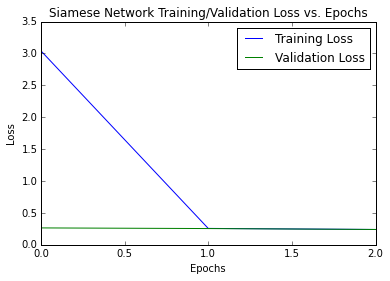

In [113]:
plt.figure()
plt.plot(l, label='Training Loss')
plt.title('Siamese Network Training/Validation Loss vs. Epochs')
plt.plot(val_l, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('siam_loss2.png')

In [114]:
def similarity(sn, x1, x2):
    x = [np.array([x1]), np.array([x2])]
    prediction = sn.predict(x, batch_size=1)
    return prediction['output'][0][0]

In [115]:
similarity(sn, x_train[0], x_train[1])

0.60172194242477417

In [119]:
num_zeros = 4913
num_ones = 9794 - 4913
num_examples = 20
sorted_index = np.argsort(y_train)[:num_zeros + num_ones]
chosen_zeros = sorted_index[random.sample(xrange(num_zeros), num_examples)]
chosen_ones = sorted_index[random.sample(xrange(num_zeros, num_zeros + num_ones), num_examples)]
indices = np.hstack((chosen_zeros, chosen_ones))
sorted_y_train = y_train[indices]
sorted_x_train = x_train[indices]

In [120]:
num_tests = len(indices)
similarity_matrix = np.zeros((num_tests, num_tests))
for i in xrange(num_tests):
    for j in xrange(num_tests):
        similarity_matrix[i][j] = similarity(sn, sorted_x_train[i], sorted_x_train[j])

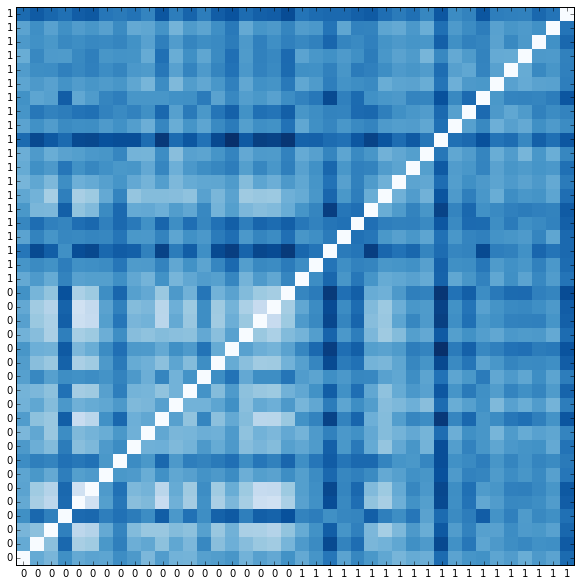

In [121]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.pcolor(similarity_matrix, cmap=matplotlib.cm.Blues)
ax.set_xticks(np.arange(similarity_matrix.shape[0])+0.5, minor=False)
ax.set_yticks(np.arange(similarity_matrix.shape[1])+0.5, minor=False)
ax.set_xticklabels(sorted_y_train, minor=False)
ax.set_yticklabels(sorted_y_train, minor=False)
plt.savefig('similarity_matrix3.png')

In [157]:
print np.mean(similarity_matrix[0:10:1,0:10:1])
print np.mean(similarity_matrix[10:20:1,10:20:1])
print np.mean(similarity_matrix[0:10:1,10:20:1])
print np.mean(similarity_matrix[10:20:1,0:10:1])

0.418063285201
0.365545945992
0.438683414161
0.438683411181
